In [1]:
# Install required packages here if needed (remove '#')
#!pip3 install pandas
#!pip3 install pandas_datareader
#!pip3 install datetime

# !pip3 install PyPortfolioOpt

In [2]:
#imports for Stock portfolio:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr

#imports for optimizing stock portfolio
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

# Predicting stock portfolio by using multivariate Normal distribution with Cholesky decomposition

## Theory
As mentioned in the single stock tool. we will still use log returns for the simulation, so the daily returns for a stock price will be:

$
Price_{t} = Price_{t-1} * e^{r}
$

for stocks portfolio with one or multiple stocks, we will be assuming daily returns are distributed by a Multivariate Normal Distribution:

$
R_t∼MVN(μ,∑) $ where ∑ is the correlation table and  μ contains the means of every stock


For sampling random daily returns for multivariate normal distribution we can make use of  Cholesky decomposition(L), normal distribution (Z_t) and the mean(μ) to calculate the daily return of 1 stock:

$
R_t=μ + LZ_t
$

$
Z_t∼N(0,I) $ Where Zt are the samples from a normal distribution (Ι represents the Identity matrix).


When all daily returns are calculated for 1 timestep for multiple stocks, to calculate the daily return of the whole portfolio on that timestep, you need to take into account the weights/stock allocations in your portfolio. so your daily log return on that timestep is:


$
R_{dailyX} = \sum _{i} ^{N} e^{(w_i*R_i)} $  where N is the number of stocks you have in your portfolio, i is the stock with the given weight and daily return and X is the timestep




finally, you can calculate every daily return and stock price in the Monto Carlo Simulation for day0 to any day you want with these functions:


$ R_{dayT} = \prod _{i} ^{T} R_{dailyI}  $    where $ R_{dayT} $ is the return between day 0 till day T

$price_t = price_0 * R_{dayT} $  where T is the day which you want to calculate the price


## get the Means(expected values) and Covs of a 1 stock or multiple

In [3]:
def read_Mean_Cov(stock_symbol, start_date, end_date):
    """Import price data from Yahoo Finance"""
    try:
        stock_data = pdr.get_data_yahoo(stock_symbol, start_date, end_date)
    except:
        return None

    prices = stock_data.loc[:, "Adj Close"] # adjusted for stock splits and dividends
    prices = prices.fillna(method="ffill")
    returns =  np.log(1+prices.pct_change()) 
    meanReturns = returns.mean()
    covReturns = returns.cov()
    return meanReturns, covReturns


stocks = ["TSLA", "F", "AAPL", "MSFT", "GOOG" ]
end_date1 = dt.datetime.now()
start_date1 = end_date1 - dt.timedelta(days=3650)


mean, cov = read_Mean_Cov(stocks, start_date1, end_date1)
print(mean)
cov

mean2, cov2 = read_Mean_Cov(['^GSPC'], start_date1, end_date1)
print(mean2)


Symbols
TSLA    0.001897
F       0.000225
AAPL    0.000826
MSFT    0.000935
GOOG    0.000716
dtype: float64
Symbols
^GSPC    0.000389
dtype: float64


'13 chapter'

Symbols
TSLA    0.001897
F       0.000225
dtype: float64
Symbols      TSLA         F
Symbols                    
TSLA     0.001258  0.000224
F        0.000224  0.000444
[0.5, 0.5]
[[0.03547342 0.        ]
 [0.00632737 0.02009971]]


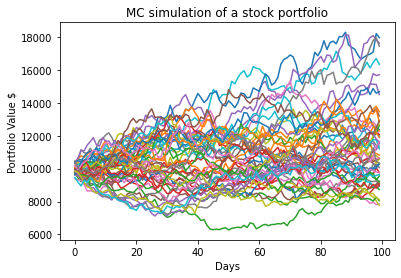

In [5]:
#Weight can be random or chosen
def monto_carlo_Sim(stocks, start_date, end_date, sims, time, weights_given):
    mean, cov = read_Mean_Cov(stocks, start_date, end_date)
    print(mean)
    print(cov)
    weights = weights_given
    if weights == []:
        weights = np.random.random(len(mean))
        weights /= np.sum(weights)
        weights
    elif np.sum(weights) != 1:
        print('Weight is not summed up to 1')
        return None
    print(weights)

    meanM = np.full(shape=(time,len(weights)), fill_value=mean)
    portfolio = np.full(shape=(time, sims), fill_value=0.0)
    initialPortfolio = 10000
    lower = np.linalg.cholesky(cov)
    print(lower)
    
    for m in range(sims):
        #MC loops
        normal = np.random.normal(size=(time,len(weights)))
        
#         dailyReturns = meanM + np.inner(lower,normal).T
        dailyReturns2 = meanM + np.dot(lower, normal.T).T
        
        weightReturns = [np.exp(r) for r in np.inner(weights, dailyReturns2)]
        portfolio[:,m] = np.cumprod(weightReturns)*initialPortfolio


    plt.plot(portfolio)
    plt.ylabel('Portfolio Value $')
    plt.xlabel('Days')
    plt.title('MC simulation of a stock portfolio')
    plt.show();    
    
    

stocks = ["TSLA", "F" ]
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=3650)
sims = 50
time = 100
# monto_carlo_Sim(stocks, start_date, end_date, sims, time, [])

monto_carlo_Sim(stocks, start_date, end_date, sims, time, [0.5,0.5])


# optimizing an stock portfolio by using PyPortfolio Opt

## Theory


 The efficient frontier is the set of optimal portfolios that offer the highest expected return for a defined level of risk or the lowest risk for a given level of expected returns. it aims to balance securities with the greatest potential returns with an acceptable degree of risk or securities with the lowest degree of risk for a given level of potential return. the efficient frontier shows the benefit of diversication. after calculating the set of optimal portfolios, you search for the point highest  Sharpe ratio(measure of risk-adjusted returns) and that point will give the optimized stock allocation.

This theory is already implemented and can be used with the library PyPortfolioOpt.

In [6]:
def read_prices(stocks, start_date, end_date): 
    try:
        stock_data = pdr.get_data_yahoo(stocks, start_date, end_date)
    except:
        return none
    prices = stock_data.loc[:, "Adj Close"] 
    prices = prices.fillna(method="ffill")
    return prices

def Optimize_Portfolio_Weights(stocks, start_date, end_date):
    prices = read_prices(stocks, start_date, end_date)
    
    # Calculate expected returns and sample covariance
    mu = expected_returns.mean_historical_return(prices)
    S = risk_models.sample_cov(prices)

    # Optimize for maximal Sharpe ratio
    ef = EfficientFrontier(mu, S)
    raw_weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    # ef.save_weights_to_file("weights.csv")  # saves to file
    print(ef.portfolio_performance(verbose=True))
    return cleaned_weights
    

stocks = ["TSLA", "F", "AAPL", "GOOG", "MSFT", "AMZN", "META", "NVDA"]
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=700)

Optimize_Portfolio_Weights(stocks, start_date, end_date)





Expected annual return: 16.6%
Annual volatility: 29.0%
Sharpe Ratio: 0.50
(0.1659976534654798, 0.29032800944206305, 0.5028714030935229)


OrderedDict([('TSLA', 0.0),
             ('F', 0.32165),
             ('AAPL', 0.67835),
             ('GOOG', 0.0),
             ('MSFT', 0.0),
             ('AMZN', 0.0),
             ('META', 0.0),
             ('NVDA', 0.0)])

In [40]:
def Optimize_Given_Funds(stocks, start_date, end_date, funds):
    weights = Optimize_Portfolio_Weights(stocks, start_date, end_date)
    print()
    print(weights)
    prices = read_prices(stocks, start_date, end_date)
    latest_prices = get_latest_prices(prices)

    da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=10000)
    allocation, leftover = da.greedy_portfolio()
    print("\nDiscrete allocation:", allocation)
    print("Funds remaining: ${:.2f}".format(leftover))
    
stocks = ["TSLA", "F", "AAPL", "GOOG", "MSFT", "AMZN", "META", "NVDA"]
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=700)
funds = 100000
Optimize_Given_Funds(stocks, start_date, end_date, funds)

Expected annual return: 28.2%
Annual volatility: 41.8%
Sharpe Ratio: 0.63
(0.28236762525039694, 0.41756880295751747, 0.6283219038206971)
OrderedDict([('TSLA', 0.28699), ('F', 0.71301), ('AAPL', 0.0), ('GOOG', 0.0), ('MSFT', 0.0), ('AMZN', 0.0), ('META', 0.0), ('NVDA', 0.0)])

Discrete allocation: {'F': 582, 'TSLA': 12}
Funds remaining: $126.01
